[View in Colaboratory](https://colab.research.google.com/github/stevecrossan/VCModel/blob/master/PortfolioSim0_5.ipynb)

This shareable document is a Google Colab notebook. It contains python code and text. The code can be run through Google Drive, by installing the Google Colab app as follows. Open Google Drive, then select My Drive -> More -> Connect More Apps. Search for Colab, and then select to install.

**Note this copy of the notebook is not editable. If you want to experiment with new code or different parameters, you can do so by making your own copy using File -> Save a copy in Drive. **

[https://colab.research.google.com/notebooks/welcome.ipynb](https://colab.research.google.com/notebooks/welcome.ipynb) gives a guide to using Colab. The basics are:



*   Connect the document to the Google Cloud runtime using the CONNECT button at the top right.
*   Once that's done you can press the play button next to each code section to execute it on Google Cloud.

Note you don't need to own any Cloud resources to do this.




---





This notebook explores assumptions and ideas about venture capital returns and portfolio size. It builds on other explorations including [Jerry Neumann's](http://reactionwheel.net/2017/12/power-laws-in-venture-portfolio-construction.html) and [Seth Levine's](https://www.sethlevine.com/archives/2014/08/venture-outcomes-are-even-more-skewed-than-you-think.html). It uses Jeff Alstott's powerlaw distribution [python library](http://www.github.com/jeffalstott/powerlaw).

Jerry Neumann's posts explore the consequences of the idea that venture returns (the returns to investments in early stage, high growth potential companies) are not normally distributed, as public market returns are, but follow a power law distribution. 

The first step is to look at the evidence that this might be so, and if so what are the approximate parameters of the distribution.

![Correlation Ventures data on U.S. Venture Returns](https://www.sethlevine.com/wp-content/uploads/venture-returns.png)

This graph is from Seth Levine's blog; the underlying data comes from Correlation Ventures, but I don't have access to the data itself.

A priori it looks as though it would be a good fit for a power law distribution.



---

Let's first install Jeff Alstot's power law distribution library. Once your notebook is Connected, press the play button on the left to install the library into the environment on Cloud:

In [1]:
!pip install powerlaw
# show which version of powerlaw was installed
!pip show powerlaw

  Running setup.py bdist_wheel for powerlaw ... - done
  Stored in directory: /content/.cache/pip/wheels/e3/e7/59/a9b3014f3e1a6899d3ad9c13c199d61f37940fb54a522195fa
Successfully built powerlaw
Name: powerlaw
Version: 1.4.3
Summary: Toolbox for testing if a probability distribution fits a power law
Home-page: http://www.github.com/jeffalstott/powerlaw
Author: Jeff Alstott
Author-email: jeffalstott@gmail.com
License: MIT
Location: /usr/local/lib/python3.6/dist-packages
Requires: 


**(Sidebar: What is a Power Law distributon?)**

---



In a power law distribution, an outcome's likelihood is inversely proportional to its size:

p(outcome) = C*outcome^-alpha

alpha is a parameter which governs the *skew* of outcomes (smaller alpha -> more skew -> more big outcomes)

Some [evidence](http://reactionwheel.net/2015/06/power-laws-in-venture.html) suggests alpha clusters around 2.

C is a constant multiplier parameterized by alpha and the minimum outcome:

C = (alpha-1)* (min_outcome)^(alpha-1)


In [0]:
# next up, import some python libraries we'll need later 
# including the powerlaw library we just installed.
import math
import random
import numpy
from enum import Enum
import powerlaw
import matplotlib.pyplot as plt

Here's the setup of some parameters.

Inital values are set to approximate some historical data from [Correlation Ventures](https://www.sethlevine.com/archives/2014/08/venture-outcomes-are-even-more-skewed-than-you-think.html) and other sources. 

In [0]:
# powerlaw alpha parameter
ALPHA = 2.0
# min outcome for powerlaw; must be > 0
MIN_OUTCOME = 0.35
# should we rebase so min outcome is zero ? 
REBASE = False
# should we use a maximum possible outcome?
USE_MAX = False
# value of maximum outcome (multiple), if used
MAX_OUTCOME = 20000.00

And here's a function (which we'll use later) to return an outcome (as multiple of capital invested) based on a power law distribution, and one to return a portfolio of a certain size drawn from that distribution.


In [0]:
# generates a pick from the VC distribution with xmin as min return and param alpha
# if the parameter cap is supplied, this is the maximum that can be returned.
def simulate_outcome_pl(alpha, xmin, cap=None):
    if(USE_MAX):
      td = powerlaw.Power_Law(xmin=xmin,xmax=MAX_OUTCOME,parameters=[alpha])
    else:
      td = powerlaw.Power_Law(xmin=xmin, parameters=[alpha])
    pick = td.generate_random(1)[0]
    if cap:
      return pick if pick < cap else cap
    return pick
  
# for reasons we'll see later let's set up the possibility of alternative
# simulation types. For the moment will just use 'powerlaw'
class SimType(Enum):
  POWERLAW = 1
  POOL = 2
  FW = 3
  CAPPED = 4
  HYBRID = 5
  HYBRID_POOL = 6
  

DEFAULT_TYPE = SimType.POWERLAW

def simulate_outcome(type):
  outcome = 0.0
  if type == SimType.POWERLAW : outcome = simulate_outcome_pl(ALPHA, MIN_OUTCOME)
  if REBASE: outcome = outcome - MIN_OUTCOME
  return outcome
  
  
# simulate a whole portfolio  
def simulate_portfolio(n_investments, type=DEFAULT_TYPE):
    results = []
    for i in range(n_investments):
      results.append(simulate_outcome(type))
    return results

Now plot a lot of outcomes and see how it compares to the Correlation Ventures data.

In [0]:
def plot_outcomes_hist(n_investments, type):
  draws = simulate_portfolio(n_investments, type)
  draws = sorted(draws)

  # helper function to label the bars
  def autolabel(bars):
    """
    Attach a text label above each bar displaying its height
    """
    for bar in bars:
        height = bar.get_height()
        pc = 100.0 * (height / n_investments)
        plt.text(bar.get_x() + bar.get_width()/2., 1.05*height,
                '%.1f' % pc,
                ha='center', va='bottom')



  bins = [-MIN_OUTCOME,1.0000001,5.01,10.01,20.01,50.01,10000]
  bin_labels = ['0-1','1-5','5-10','10-20','20-50','50+']
  yticks = [0,1000,2000,3000,4000,5000,6000]
  ytick_labels = ['0%','10%','20%','30%','40%','50%','60%']
  hist, edges = numpy.histogram(draws, bins)
  print(hist)
  bars = plt.bar(numpy.arange(6),hist)
  plt.xticks(numpy.arange(6), bin_labels)
  plt.yticks(yticks, ytick_labels)
  autolabel(bars)
  rebased = ' rebased' if REBASE else ''
  title = 'Histogram of ' + str(n_investments) + ' ' + str(type) + ' outcomes' + rebased
  plt.title(title)
  plt.show()

[6500 2802  357  166   99   76]


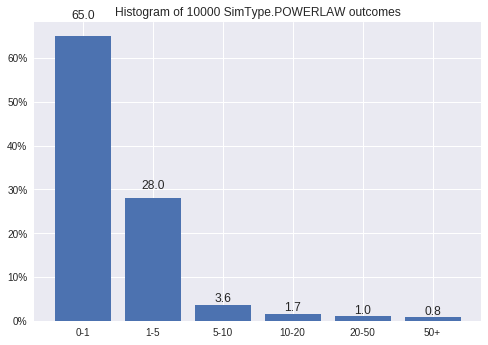

In [7]:
plot_outcomes_hist(10000, SimType.POWERLAW)

Looks like it's in the right ballpark. 

Here are some functions to run a number (ITERATIONS) of simulations and summarize their outcomes.

In [0]:
# Simulate each portfolio this many times to get mean etc.
ITERATIONS = 1000


# a helper function.
# what is the return of the top nth percentile of the portfolio?
def percentile_return(n, portfolio):
    portfolio = list(reversed(sorted(portfolio)))
    l = len(portfolio)
    pctile = (n* l / 100.0)
    index = math.floor(pctile)
    remainder = pctile - index
    sum = 0.0
    for i in range(int(index)):
        sum += portfolio[i]
    next = portfolio[index]
    # add the pro rata of the next most valuable deal
    sum += next * remainder
    return sum
    
  


# run ITERATIONS simulations of a portfolio of n_investments
# and summarize their statistics
def run_simulations(n_investments, type):
    runs = {}
    # the mean return of each portfolio
    means = []
    sums = []
    # the ratio of the biggest return to the total portfolio
    max_ratios = []
    # the ratio of the biggest return to the fund
    max_to_fund_ratios = []
    # the ratio of the top 1% and 5% of investments
    one_pc_ratios, five_pc_ratios = [], []
    # the ratio of the biggest return to the mean and median
    max_to_mean_ratios, max_to_median_ratios = [], []
    
    for i in range(ITERATIONS):
      portfolio = simulate_portfolio(n_investments, type)
      portfolio = sorted(portfolio)
      means.append(numpy.mean(portfolio))
      total = sum(portfolio)
      one_pc_ratios.append(
          percentile_return(1, portfolio) / total if total > 0.0 else 0.0)
      five_pc_ratios.append(
          percentile_return(5, portfolio) / total if total > 0.0 else 0.0)
      max_to_mean_ratios.append(
          numpy.max(portfolio) / numpy.mean(portfolio) if total > 0.0 else 0.0)
      max_to_median_ratios.append(
          numpy.max(portfolio) / numpy.median(portfolio) 
            if numpy.median(portfolio) > 0.0 else 0.0)
      n = len(portfolio)
      max_ratios.append(portfolio[n-1] / total if total > 0.0 else 0.0)
      max_to_fund_ratios.append(portfolio[n-1] / n)
      
    runs['means'] = means
    runs['max_ratios'] = max_ratios
    runs['max_to_fund_ratios'] = max_to_fund_ratios
    runs['one_pc_ratios'] = one_pc_ratios
    runs['five_pc_ratios'] = five_pc_ratios
    runs['max_to_mean_ratios'] = max_to_mean_ratios
    runs['max_to_median_ratios'] = max_to_median_ratios
      
    return runs

# this helper function summarizes the simulations of a portfolio of a 
# particular size
def summarize(runs):
  iterations = len(runs)
  summary = {}
  summary ['mean'] = numpy.mean(runs)
  summary ['median'] = numpy.median(runs)
  summary ['min'] = numpy.min(runs)
  summary ['max'] = numpy.max(runs)
  # percentage of times the fund more than triples
  summary ['tripled'] = (sum(i >= 3.0 for i in runs) / iterations) * 100.0
  summary ['five_x'] = (sum(i >=5.0 for i in runs) / iterations) * 100.0
  summary ['ten_x'] = (sum (i >= 10.0 for i in runs) / iterations) * 100.0
  # percentage of times the fund loses money
  summary ['lost'] = (sum(i < 1.0 for i in runs) / iterations) * 100.0
  summary ['variance'] = numpy.var(runs)
  return summary

# plot a single portfolio
def plot_portfolio(portfolio):
  portfolio = sorted(portfolio)
  plt.bar(numpy.arange(len(portfolio)), portfolio)
  plt.show()
 


Monte-carlo simulate portfolios of a number of sizes, and plot the last (largest) one as an example.

In [0]:

# run and summarize a bunch of portfolios between 'smallest' and 'largest'
# size. Each portfolio is simulated ITERATIONS times
def sim_portfolio_sizes(smallest, largest, type=SimType.POWERLAW):
  results = {}
  summaries = {}
  max_ratio_means = {}
  max_to_fund_ratio_means = {}
  one_pc_means, five_pc_means = {}, {}
  
  # try portfolio sizes between smallest and largest
  for i in range (smallest, largest):
    runs = run_simulations(i, type)
    summaries[i] = summarize(runs['means'])
    max_ratio_means[i] = numpy.mean(runs['max_ratios'])
    max_to_fund_ratio_means[i] = numpy.mean(runs['max_to_fund_ratios'])
    one_pc_means[i] = numpy.mean(runs['one_pc_ratios'])
    five_pc_means[i] = numpy.mean(runs['five_pc_ratios'])
    
  losses = []
  triples = []
  five_xs = []
  ten_xs = []
  means = []
  medians = []
  maxes = []
  mins = []
  for i in summaries.keys():
    losses.append(summaries[i]['lost'])
    triples.append(summaries[i]['tripled'])
    ten_xs.append(summaries[i]['ten_x'])
    five_xs.append(summaries[i]['five_x'])
    means.append(summaries[i]['mean'])
    medians.append(summaries[i]['median'])
    maxes.append(summaries[i]['max'])
    mins.append(summaries[i]['min'])
    
  results ['summaries'] = summaries
  results ['max_ratio_means'] = max_ratio_means
  results ['max_to_fund_ratio_means'] = max_to_fund_ratio_means
  results ['one_pc_means'] = one_pc_means
  results ['five_pc_means'] = five_pc_means
  results ['losses'] = losses
  results ['triples'] = triples
  results ['five_xs'] = five_xs
  results ['ten_xs'] = ten_xs
  results ['means'] = means
  results ['medians'] = medians
  results ['maxes'] = maxes
  results ['mins'] = mins
    
  return results


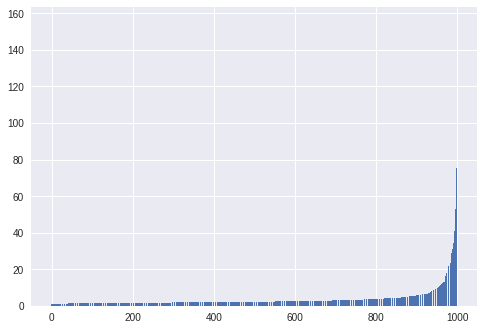

In [18]:
# plot a portfolio of 100 as an example
runs = run_simulations(100, SimType.POWERLAW)
plot_portfolio(runs['means'])

This plot shows something interesting. It's a plot summarizing the returns of 1000 simulations of a portfolio of 100 investments with the outcomes taken from a power law distribution. The simulation outcomes are arranged in size order.

A power law distribution has no maximum possible outcome - but outcomes become less likely the larger they are. This means that in 1000 simulations you occasionally (right hand side) get very very large outcomes (several 100x). 

Now let's plot what we're really interested in: how do outcomes vary by portfolio size. Let's look at the percentage chance of failure (total portfolio return < 1x), trippling, 5x, and 10x.

In [0]:

def plot_results(title, results):
  keys = results['summaries'].keys()
  plt.plot(list(keys), results['losses'], label='lost money')
  plt.plot(list(keys), results['triples'], label='tripled money')
  plt.plot(list(keys), results['five_xs'], label='five x-ed money')
  plt.plot(list(keys), results['ten_xs'], label='ten x-ed money')
  plt.title(title)
  plt.legend()
  plt.show()

In [0]:
#results['summaries']

This next piece of code actually runs a number of simulations at different portfolio sizes. It needs everything above to have been run (Runtime->Run Before is your friend). It takes a couple of minutes to execute. 

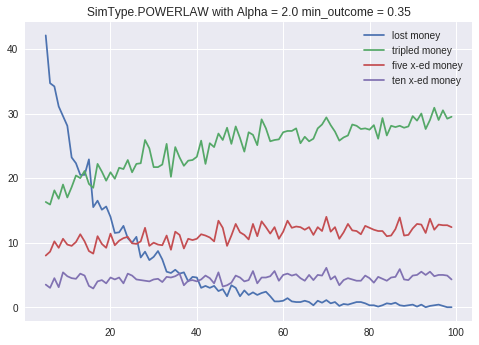

In [26]:
# simulate portfolios between 5 and 300 investments from SimType.POWERLAW
results = sim_portfolio_sizes(5,300, SimType.POWERLAW)
title = str(
    SimType.POWERLAW) + ' with Alpha = ' + str(
    ALPHA) + ' min_outcome = ' + str(MIN_OUTCOME)
plot_results(title, results)

Let's now look at some other stats on the returns - e.g. the min/max/mean of the 1000 simulations we did at each portfolio size.

In [0]:

def plot_stat(title, stat, results):
  plt.plot(list(results['summaries'].keys()), results[stat], label='min')
  plt.legend()
  plt.title(title)
  plt.show()

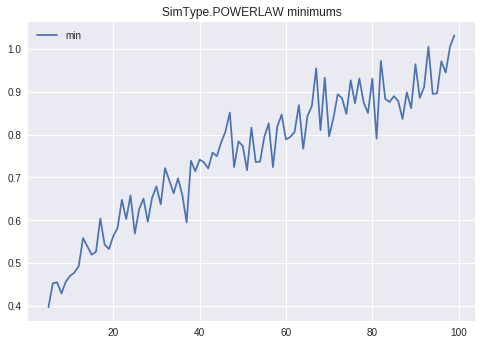

In [30]:
plot_stat('SimType.POWERLAW minimums', 'mins', results)

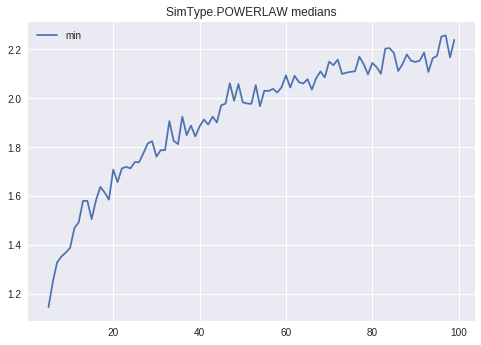

In [31]:
plot_stat('SimType.POWERLAW medians', 'medians', results)

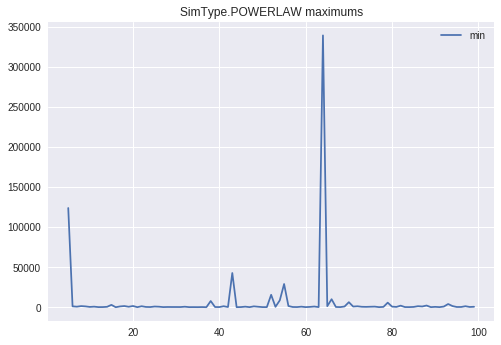

In [32]:
plot_stat('SimType.POWERLAW maximums', 'maxes', results)

What's going on with this last one ? 

In total we simulated sum(x=5->300) x*1000 independent outcomes which is over 45M outcomes.

A feature of the raw PowerLaw distribution is that it is uncapped. Every so often, you get a really crazy outcome (several hundred thousand x, or more), which can then obscure the trend. One way to deal with this is to set the USE_MAX parameter to true.

But there may be a more 'realistic' way forward in practice portfolios are not completely independent; VCs often invest in the same companies as other VCs. In the life of a fund, there is a finite pool or cohort of investible businesses which is the universe from which we're drawing. 

How about instead we create a cohort of businesses that receive investment, and our portfolios sample from this pool? 

According to [Crunchbase],(https://news.crunchbase.com/news/q3-2017-global-report-vc-deal-dollar-volume-projected-reach-post-dot-com-highs/), globally seed rounds have been running at about 3,500 per quarter. Let's round up to 4,000 to allow for growth. So the global pool of investable deals per year is around 16,000, or 80,000 over the 5 year investing life of a typical portfolio.

In [0]:
POOL_SIZE = 80000
td = powerlaw.Power_Law(xmin=MIN_OUTCOME,  parameters=[ALPHA])
POOL = td.generate_random(POOL_SIZE)
THRESHOLD = numpy.percentile(POOL, 33.33)

Then we have to modify simulate_outcome to pick a random outcome from this pool. The idea is to model a fund that's choosing from a fixed 'universe' of investments.

In [0]:
# return a random entry from the pool of power law draws
def simulate_outcome_pool(pool):
  return pool[random.randint(0,POOL_SIZE-1)]
  return 0

While we're here, let's define a couple more simulation types:

1) The Fred Wilson draw: 1/3 go to zero, 1/3 return 1x, 1/3 are powerlaw distributed with minimum 1.0.

2) Can returns really go to 100,000 ? Try a model with returns capped at 10,000 (Jerry Neumann's estimate of the return to the first check into Google)

3) The powerlaw distribution never actually goes to zero. Does this make a difference ? Try a hybrid of Fred Wilson & PowerLaw: 1/3 go to zero, 2/3 powerlaw.

In [0]:
# while we're here, some alternative models
def simulate_outcome_fw(alpha, min_outcome):
  pn=numpy.random.randint(0,3)
  if pn==2:
    return simulate_outcome_pl(alpha,min_outcome)
  return pn

def simulate_outcome_hybrid(alpha, min_outcome):
  pn=numpy.random.randint(0,3)
  if pn==0:
    return pn
  return simulate_outcome_pl(alpha, min_outcome)

# squash outcomes below threshold to zero
def simulate_outcome_hybrid_pool(pool, threshold):
  outcome = simulate_outcome_pool(pool)
  return outcome if outcome > threshold else 0.0


# redefine simulate outcome to choose between independent power law draws
# or draws from a pool of results
def simulate_outcome(type):
  outcome = 0.0
  if type == SimType.POWERLAW : outcome = simulate_outcome_pl(ALPHA, MIN_OUTCOME)
  if type == SimType.FW : outcome = simulate_outcome_fw(ALPHA, 1.0)
  if type == SimType.CAPPED : outcome = simulate_outcome_pl(ALPHA, MIN_OUTCOME, 10000.0)
  if type == SimType.HYBRID : outcome = simulate_outcome_hybrid(ALPHA, 0.5)
  if type == SimType.POOL : outcome = simulate_outcome_pool(POOL)
  if type == SimType.HYBRID_POOL : 
    outcome = simulate_outcome_hybrid_pool(POOL, THRESHOLD)
  if REBASE: outcome = outcome - MIN_OUTCOME
  return outcome

Look at the histograms

[6444 2805  381  196  108   66]


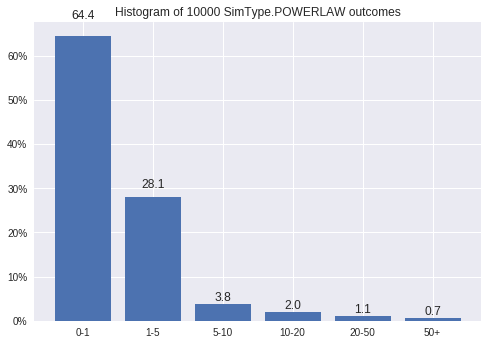

[6708 2603  337  169  114   68]


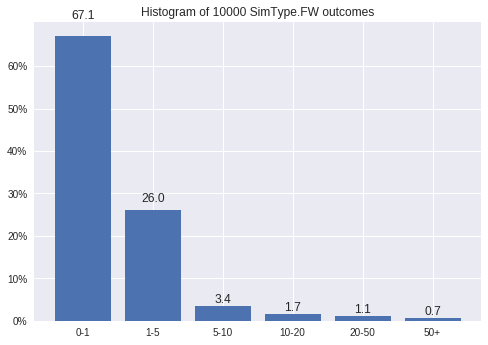

[6382 2896  361  175  117   69]


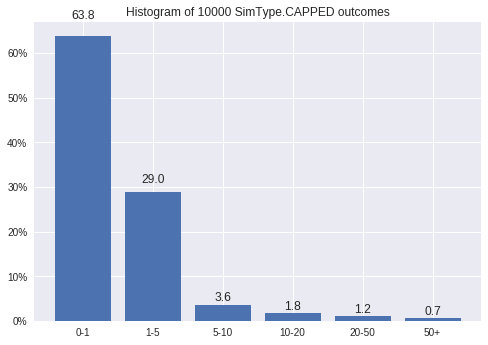

[6660 2671  339  176  107   46]


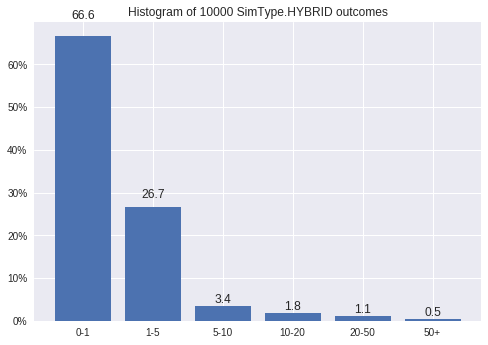

[6568 2741  348  188   83   72]


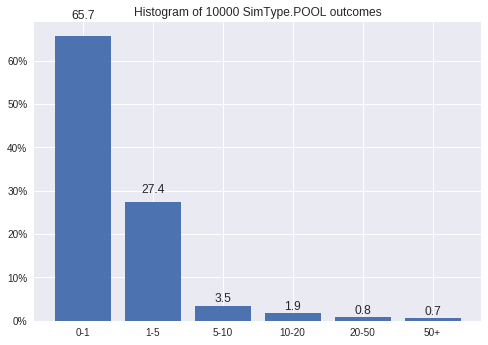

[6518 2811  338  163  110   60]


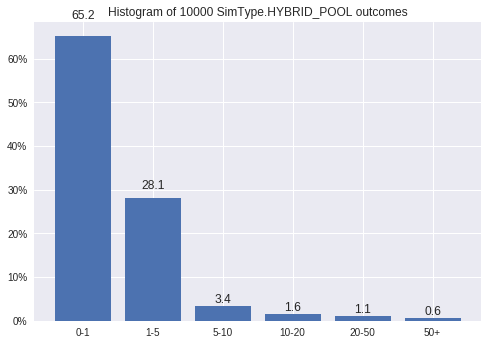

In [50]:
plot_outcomes_hist(10000, SimType.POWERLAW)
plot_outcomes_hist(10000, SimType.FW)
plot_outcomes_hist(10000, SimType.CAPPED)
plot_outcomes_hist(10000, SimType.HYBRID)
plot_outcomes_hist(10000, SimType.POOL)
plot_outcomes_hist(10000, SimType.HYBRID_POOL)

So at first glance any of these kind of model the data we have reasonably.

Then let's run the simulations again to compare, but this time from the pool. Note what we're doing is simulating 1000 portfolios at each size from 5 to 300 investments, each choosing from the same fixed universe of investments. So we're sampling 296,000 outcomes from the pool, with replacement.

In [0]:
pool_results = sim_portfolio_sizes(5, 300, SimType.POOL)

In [0]:
# these are expensive to run, so let's persist them
from google.colab import files
import pickle

def local_persist(fname, results):
  fname = fname + '.txt'
  pickle.dump(results, open(fname, 'wb'))
  files.download(fname)

In [0]:
# OPTIONAL: you don't have to run this to make everything else work
# It just saves your results to a file so you don't have to re-run them
# each time. Uncomment if you want to run.
# local_persist('pool_results_alpha_2.0_min_0.35_80K', pool_results)

And some code to load them back from files.

In [0]:
from io import BytesIO

# function to restore from local storage
def load_from_local():
  loaded = {}
  uploaded = files.upload()
  for name in uploaded.keys():
      data = uploaded[name]
      loaded[name] = pickle.load(BytesIO(data))
  return loaded
 

In [0]:
#OPTIONAL again: uncomment if you want to run
#pool_results = loaded['pool_results_alpha_2.0_min_0.35_80K.txt']

Saving pool_results_alpha_2.1_min_0.7_80K_rebased_300.txt to pool_results_alpha_2.1_min_0.7_80K_rebased_300.txt


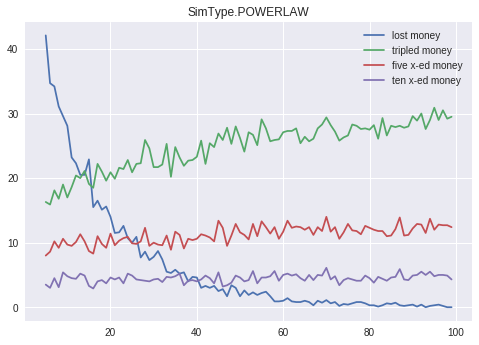

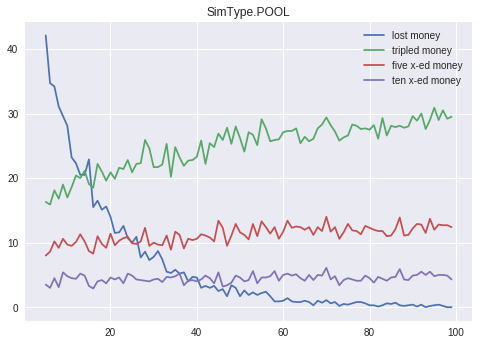

In [53]:
# first plot again the independent power law results
plot_results(str(SimType.POWERLAW), results)
# then the pooled results for comparison
plot_results(str(SimType.POOL), results)
#plot_results(str(SimType.HYBRID_POOL), hybrid_pool_results)
#plot_results(str(SimType.FW), fw_results)
#plot_results(str(SimType.CAPPED), capped_results)
#plot_results(str(SimType.HYBRID), hybrid_results)


What does this show ? All the alternative distributions have similar shapes with respect to the chances of various benchmark outcomes.

Importantly, they all do better the more investments you make. My intuition is that this is because in every model, very large outcomes are possible but extremely rare. Thus the larger your portfolio, the more likely you are to hit one of those outliers, and the size of that outlier will tend to dominate the portfolio return (see also below for a specific exploration of this effect)

However, apart from the pooled model (where each portfolio is a pick from a fixed 'universe' of POOL_SIZE companies - default POOL_SIZE = 50K), they all approach nearly a 1 in 10 chance of 10x-ing your money. So where are all the 10x funds ? Perhaps the fact that most portfolios are below 100 plays a role. But perhaps this is evidence that the pool model is more realistic.

Now let's look at minimum returns

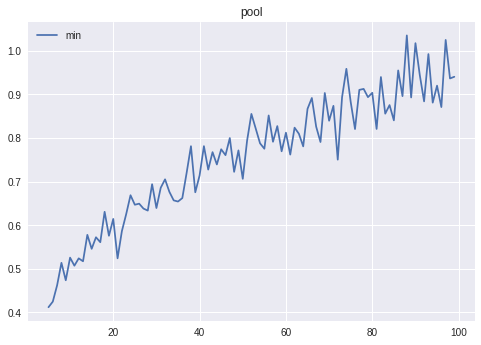

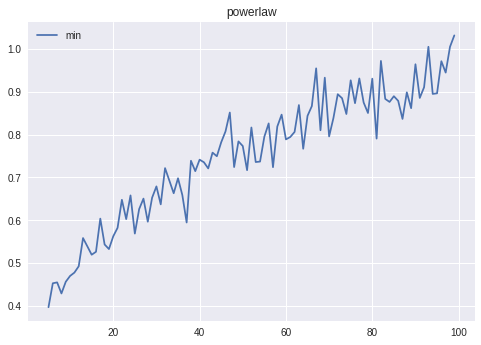

In [54]:
plot_stat('pool', 'mins', pool_results)
plot_stat('powerlaw', 'mins', results)
#plot_stat('fw', 'mins', fw_results)
#plot_stat('capped', 'mins', capped_results)
#plot_stat('hybrid', 'mins', hybrid_results)

Again very similar. After portfolio sizes of 150, there are basically no funds within 1000 simulations that return less than 1x.

And maximums.

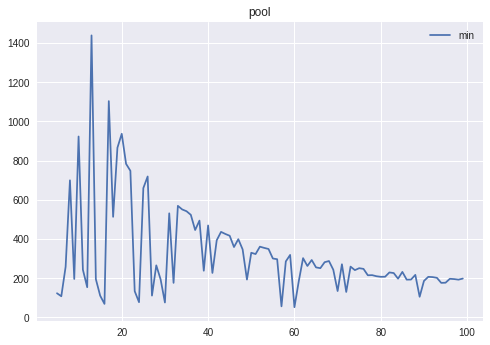

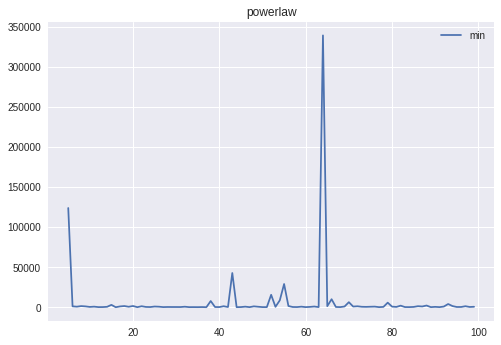

In [55]:
plot_stat('pool', 'maxes', pool_results)
plot_stat('powerlaw', 'maxes', results)
#plot_stat('fw', 'maxes', fw_results)
#plot_stat('capped', 'maxes', capped_results)
#plot_stat('hybrid', 'maxes', hybrid_results)

OK these are properly different: pooled and capped v. different from the other 3, and the other 3 are wierd.

My interpretation is that with the other 3, there's no maximum to the upside. In total we're simulating sum(x=5->100) 1000*x independent companies, which is over 45M companies. Every so often we hit a multiple in the 100,000x range or even MMx range, which then dominates the average at that pool size.

In the other 2 models an individual outcome is capped, in 1 case because we're drawing from a fixed pool of 50K companies, and the other because we introduced a cap of 10,000x. The curve that both show is the result of averaging effects as the portfolios get progressively larger.

Now let's look at the means.

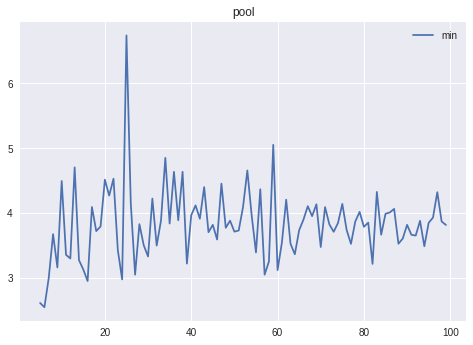

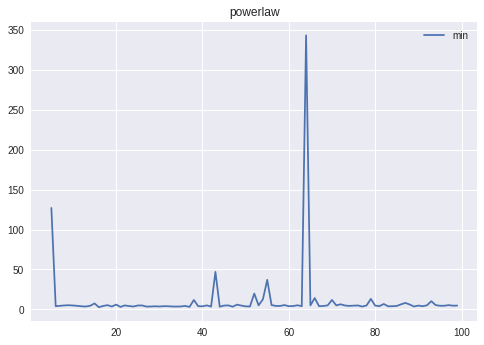

In [56]:
plot_stat('pool', 'means', pool_results)
plot_stat('powerlaw', 'means', results)
#plot_stat('fw', 'means', fw_results)
#plot_stat('capped', 'means', capped_results)
#plot_stat('hybrid', 'means', hybrid_results)

Again, pool and capped look like the more realistic ones here. However both are super-high when you get beyond even a few dozen investments. The data I've seen so far suggests mean venture returns are lower (but sample bias may play a role), so something fishy going on here that I need to look into.

And finally let's plot the ratios of the best investment, 1% of invested capital and 5% of invested capital, to total portfolio at different sizes.

In [0]:
def plot_ratios(title, results):
  
  max_ratio_means = results['max_ratio_means']
  max_to_fund_ratio_means = results['max_to_fund_ratio_means']
  one_pc_means = results['one_pc_means']
  five_pc_means = results['five_pc_means']

  plt.ylabel('ratio')
  plt.plot(list(max_ratio_means.keys()), list(max_ratio_means.values()), label='ratio of best investment to total return')
  #plt.plot(list(max_to_fund_ratio_means.keys()), list(max_to_fund_ratio_means.values()), label='ratio of best to fund size')
  plt.plot(list(one_pc_means.keys()), list(one_pc_means.values()), label = 'top percentile ratio')
  plt.plot(list(five_pc_means.keys()), list(five_pc_means.values()), label = 'top 5 percentile ratio')

  plt.legend()
  plt.title(title)
  plt.show()

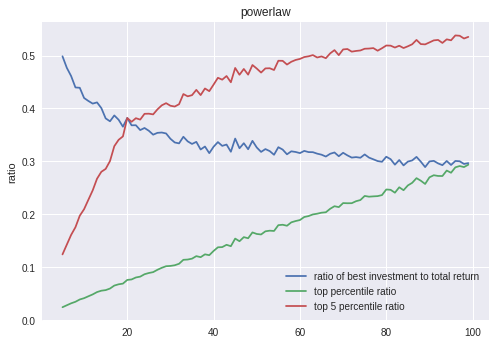

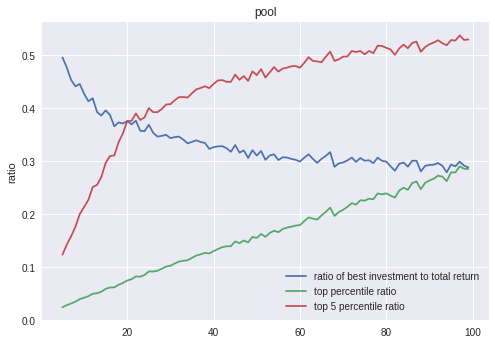

In [64]:
plot_ratios('powerlaw', results)
plot_ratios('pool', pool_results)


These look very consistent (and interesting). 1% of invested capital seems to grow asymptotically to about 50% of the total return, and 5% to about 70%. The contribution of the single most successful investment goes down as the portfolio size grows, as you'd expect, but still bottoms out around 30%. This seems to be true even in the 'limited' models.